In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import joblib

ImportError: cannot import name 'joblib' from 'sklearn.externals' (/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/externals/__init__.py)

Prepare data

In [29]:
# df = pd.read_csv('merged.csv')

# X = df.drop(['label'], axis=1)  # Drop 'label' column
# y = df['label'] # Keep only labels

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

Prepare data with specified ratios of malicious/benign data

In [2]:
# All features: 'name', 'packages', 'version', 'average_entropy', 'python_file_count', 'package_size', 'contains_ip', 'contains_domain', 'contains_bytestrings', 'contains_base64', 'contains_import_subprocess', 'contains_import_os', 'contains_import_network_modules'

# Specify the columns to exclude
columns_to_exclude =  []

# Read the CSV file excluding specified columns
df = pd.read_csv('merged.csv', usecols=lambda x: x not in columns_to_exclude)

# Split the dataset into malicious and benign subsets
malicious_df = df[df['label'] == 1]
benign_df = df[df['label'] == 0]

# Desired test size and malicious ratio in the test set
test_size = 0.2
malicious_ratio_in_test = 0.1

# Calculate the number of malicious samples in the test set
total_test_samples = int(len(df) * test_size)
malicious_test_samples = int(total_test_samples * malicious_ratio_in_test)
benign_test_samples = total_test_samples - malicious_test_samples

# Split the malicious data
malicious_train, malicious_test = train_test_split(malicious_df, test_size=malicious_test_samples, random_state=42)

# Split the benign data
benign_train, benign_test = train_test_split(benign_df, test_size=benign_test_samples, random_state=42)

# Combine the training and testing sets
train_df = pd.concat([malicious_train, benign_train])
test_df = pd.concat([malicious_test, benign_test])

# Shuffle the training and testing sets to ensure random distribution
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and labels for training and testing sets
X_train = train_df.drop(['label'], axis=1)
y_train = train_df['label']
X_test = test_df.drop(['label'], axis=1)
y_test = test_df['label']

# Print the sizes of the training and test data
print(f'Training set size: {len(X_train)} samples')
print(f'Test set size: {len(X_test)} samples')

# Output the shapes to verify the splits
print(f'Training set shape: {X_train.shape}, {y_train.shape}')
print(f'Test set shape: {X_test.shape}, {y_test.shape}')
print(f'Class distribution in test set:\n{y_test.value_counts()}')

Training set size: 1920 samples
Test set size: 480 samples
Training set shape: (1920, 13), (1920,)
Test set shape: (480, 13), (480,)
Class distribution in test set:
label
0    432
1     48
Name: count, dtype: int64


Train RF Classifier

In [3]:
# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, 'pyscan.pkl')

RandomForestClassifier(random_state=42)

Make predictions

In [4]:
# Predict on the test set
y_pred = rf_model.predict(X_test)

Evaluate results

In [5]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.96
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       432
           1       0.73      0.96      0.83        48

    accuracy                           0.96       480
   macro avg       0.86      0.96      0.90       480
weighted avg       0.97      0.96      0.96       480

Confusion Matrix:
[[415  17]
 [  2  46]]


Examine feature importance

In [6]:
# Feature importance
if columns_to_exclude:
    remaining_columns = [col for col in X_train.columns if col not in columns_to_exclude]
    if len(remaining_columns) == len(rf_model.feature_importances_):
        feature_importances_adjusted = pd.Series(rf_model.feature_importances_, index=remaining_columns)
        print('Adjusted Feature Importances:')
        print(feature_importances_adjusted)
    else:
        print('Number of remaining columns does not match the length of feature importances.')
else:
    feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
    print('Feature Importances:')
    print(feature_importances)

Feature Importances:
name                               0.012753
packages                           0.023627
version                            0.015895
average_entropy                    0.168633
python_file_count                  0.371525
package_size                       0.257013
contains_ip                        0.023701
contains_domain                    0.001149
contains_bytestrings               0.068704
contains_base64                    0.000785
contains_import_subprocess         0.010613
contains_import_os                 0.016012
contains_import_network_modules    0.029589
dtype: float64


Examine results

In [7]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Display the results
print(results_df)

print(f"Flagged {results_df[results_df['Predicted'] == 1].shape[0]} out of {results_df[results_df['Actual'] == 1].shape[0]} malicious samples")
print(f"Flagged {(results_df[results_df['Predicted'] == 1].shape[0] / len(X_train) ) * 100} percent of samples")
print(f"{test_size * 100}% reserved for test")
print(f"{malicious_ratio_in_test * 100}% of test was malicious")

     Actual  Predicted
0         0          0
1         0          0
2         0          0
3         0          0
4         0          0
..      ...        ...
475       0          0
476       0          0
477       0          0
478       0          1
479       0          0

[480 rows x 2 columns]
Flagged 63 out of 48 malicious samples
Flagged 3.28125 percent of samples
20.0% reserved for test
10.0% of test was malicious


Plot ROC Curve

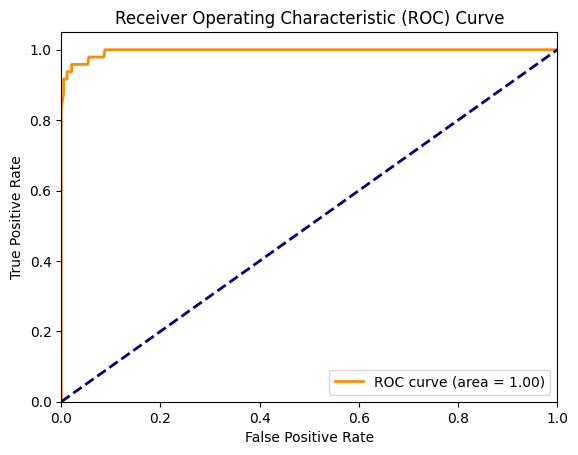

In [8]:
# Predict probabilities for the test set
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()